[*********************100%***********************]  1 of 1 completed
[[0.47185126 0.52814874]
 [0.52327227 0.47672773]
 [0.5291831  0.4708169 ]
 ...
 [0.5041447  0.4958553 ]
 [0.48476226 0.51523774]
 [0.45467958 0.54532042]]
[[ 89 268]
 [ 86 306]]
              precision    recall  f1-score   support

          -1       0.51      0.25      0.33       357
           1       0.53      0.78      0.63       392

    accuracy                           0.53       749
   macro avg       0.52      0.51      0.48       749
weighted avg       0.52      0.53      0.49       749

0.527369826435247


C:\Users\priya veda\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[0.532      0.5        0.476      0.54       0.47791165 0.51807229
 0.55823293 0.57028112 0.52208835 0.5060241 ]
0.5200610441767068


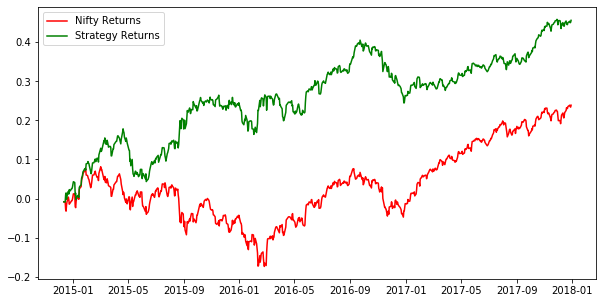

Date
2007-10-12   -1
2007-10-15    1
2007-10-16   -1
2007-10-17   -1
2007-10-18   -1
             ..
2017-12-22    1
2017-12-26    1
2017-12-27   -1
2017-12-28    1
2017-12-29    1
Name: Predicted_Signal, Length: 2494, dtype: int32

In [12]:
# ## Import the Libraries

# Data Manupulation
import numpy as np
import pandas as pd

# Techinical Indicators
import talib as ta

# Plotting graphs
import matplotlib.pyplot as plt

# Machine learning
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score

# Data fetching
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()


# ## Import the data
df = pdr.get_data_yahoo('^NSEI', '2000-01-01', '2018-01-01')
df = df.dropna()
df = df.iloc[:,:4]
df.head()


# ## Create Indicators
df['S_10'] = df['Close'].rolling(window=10).mean()
df['Corr'] = df['Close'].rolling(window=10).corr(df['S_10'])
df['RSI'] = ta.RSI(np.array(df['Close']), timeperiod =10)
df['Open-Close'] = df['Open'] - df['Close'].shift(1)
df['Open-Open'] = df['Open'] - df['Open'].shift(1)
df = df.dropna()
X = df.iloc[:,:9]
y = np.where(df['Close'].shift(-1) > df['Close'],1,-1)

# ## Logistic Regression

# ### Split the Dataset and Instantiate Logistic Regression
split = int(0.7*len(df))
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

model = LogisticRegression()
model = model.fit (X_train,y_train)
pd.DataFrame(zip(X.columns, np.transpose(model.coef_)))

probability = model.predict_proba(X_test)
print(probability)

predicted = model.predict(X_test)

print(metrics.confusion_matrix(y_test, predicted))

print(metrics.classification_report(y_test, predicted))

print(model.score(X_test,y_test))  

cross_val = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=10)
print(cross_val)
print(cross_val.mean())


# ## Create a Trading Strategy
df['Predicted_Signal'] = model.predict(X)
df['Nifty_returns'] = np.log(df['Close']/df['Close'].shift(1))
Cumulative_Nifty_returns = np.cumsum(df[split:]['Nifty_returns'])

df['Startegy_returns'] = df['Nifty_returns']* df['Predicted_Signal'].shift(1)
Cumulative_Strategy_returns = np.cumsum(df[split:]['Startegy_returns'])

plt.figure(figsize=(10,5))
plt.plot(Cumulative_Nifty_returns, color='r',label = 'Nifty Returns')
plt.plot(Cumulative_Strategy_returns, color='g', label = 'Strategy Returns')
plt.legend()
plt.show()